In [2]:
import datetime
import pathlib
import typing
import collections

from absl import flags
from absl import logging
import humanize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from experimental.polyglot.baselines import get_instances
from deeplearning.clgen import clgen
from deeplearning.clgen import errors
from deeplearning.clgen.corpuses import corpuses
from deeplearning.clgen.proto import corpus_pb2
from deeplearning.clgen.proto import clgen_pb2
from deeplearning.clgen.proto import model_pb2
from deeplearning.clgen.proto import sampler_pb2
from lib.labm8 import bazelutil
from lib.labm8 import pbutil
from lib.labm8 import viz

FLAGS = flags.FLAGS(['argv[0]', '--logtostderr'])

In [ ]:
instances = get_instances.GetInstances()
print("Loaded {} instances".format(len(instances)))

In [7]:
def GetOutputCorpus(instance: clgen.Instance) -> corpuses.Corpus:
    with instance.Session():
        out_dir = instance.model.SamplerCache(instance.sampler)
        if not out_dir.is_dir():
            return None
        output_corpus_config = corpus_pb2.Corpus()
        output_corpus_config.CopyFrom(instance.model.corpus.config)
        output_corpus_config.local_directory = str(out_dir) + '.contentfiles'
        if not pathlib.Path(output_corpus_config.local_directory).is_dir():
            return None
        return corpuses.Corpus(output_corpus_config)

output_corpuses = [GetOutputCorpus(i) for i in instances]
print("Loaded {} output corpuses".format(len([x for x in output_corpuses if x])))

Loaded 6 output corpuses


In [11]:
def InstanceStats(instance: clgen.Instance, output_corpus: corpuses.Corpus) -> typing.Dict[str, typing.Any]:
    stats = collections.OrderedDict()
    stats['Language'] = {
        'opencl': 'OpenCL',
        'java': 'Java',
    }[pathlib.Path(instance.model.corpus.config.local_directory).stem]
    with instance.Session():
        instance.model.corpus.Create()
    stats['Encoding'] = 'Character' if 'Ascii' in str(instance.model.corpus.atomizer) else 'Token'
    stats['Vocab size'] = instance.model.corpus.atomizer.vocab_size
    stats['Corpus size'] = '{:.1f}M'.format(instance.model.corpus.encoded.token_count / 1e6)
    # stats['Embedding'] = instance.model.config.architecture.embedding_size
    stats['Model size'] = f'{instance.model.config.architecture.neurons_per_layer}x{instance.model.config.architecture.num_layers}'
    # stats['Dropout'] = instance.model.config.architecture.post_layer_dropout_micros / 1e6
    if instance.model.config.training.HasField('adam_optimizer'):
        stats['Optimizer'] = 'Adam'
        stats['Learning rate'] = instance.model.config.training.adam_optimizer.initial_learning_rate_micros / 1e6
        stats['Decay'] = instance.model.config.training.adam_optimizer.learning_rate_decay_per_epoch_micros / 1e6
    else:
        stats['Optimizer'] = 'RMSProp'
        stats['Learning rate'] = instance.model.config.training.rmsprop_optimizer.initial_learning_rate_micros / 1e6
        stats['Decay'] = instance.model.config.training.rmsprop_optimizer.learning_rate_decay_per_epoch_micros / 1e6
    telemetry = instance.model.TrainingTelemetry()
    if telemetry:
        stats['Epochs'] = len(telemetry)
        stats['Final Loss'] = '{:.3f}'.format(telemetry[-1].loss)
        stats['Training time'] = humanize.naturaldelta(
            datetime.timedelta(seconds=sum(t.epoch_wall_time_ms for t in telemetry) / 1e3))
        stats['Time / epoch'] = humanize.naturaldelta(
            datetime.timedelta(seconds=np.array([t.epoch_wall_time_ms for t in telemetry]).mean() / 1e3))

    if output_corpus:
#         with instance.Session():
#             try:
#                 output_corpus.Create()
#             except errors.EmptyCorpusException:
#                 pass
        samples_dir = instance.model.SamplerCache(instance.sampler)
        sample_times = np.array([
            pbutil.FromFile(samples_dir / f, model_pb2.Sample, uninitialized_okay=True).wall_time_ms for f in samples_dir.iterdir()
        ], dtype=np.int32)
        # TODO(cec): Use the number of extracted kernels, not the number of samples themselves.
        # Sample times is in milliseconds, and we want time per thousand, so they cancel out.
        # Average sample time in seconds.
        sample_time_seconds = sample_times.mean() / 1000
        stats['Sample temperature'] = humanize.intcomma(instance.sampler.temperature)
        stats['Output samples'] = humanize.intcomma(output_corpus.preprocessed.input_size)
        stats['Output vocab size'] = humanize.intcomma(output_corpus.vocab_size)
        stats['Time / sample (ms)'] = int(round(sample_times.mean()))
        sample_throughput = (24 * 3600) / sample_time_seconds
        stats['Samples / day'] = '{:.1f}k'.format(sample_throughput / 1000)
        # stats['Time / 1k samples'] = humanize.naturaldelta(
        #     datetime.timedelta(seconds=samples_time_seconds * 1000))
        if output_corpus.preprocessed.size:
            efficiency = (output_corpus.preprocessed.size / 
                          (output_corpus.preprocessed.input_size or 1))
            good_sample_throughput = efficiency * sample_throughput
            stats['Efficiency'] = '{:.2%}'.format(efficiency)
            stats['Throughput / day'] = '{:.1f}k'.format(good_sample_throughput / 1000)
    return stats

stats = pd.DataFrame([InstanceStats(i, o) for i, o in zip(instances, output_corpuses)]).fillna('-')
stats

,Language,Encoding,Vocab size,Corpus size,Model size,Optimizer,Learning rate,Decay,Epochs,Final Loss,Training time,Time / epoch,Sample temperature,Output samples,Output vocab size,Time / sample (ms),Samples / day,Efficiency,Throughput / day
0,OpenCL,Character,92,21.8M,512x2,Adam,0.002,0.05,50,0.156,4 hours,5 minutes,1.0,"5,054",52,431,200.3k,3.46%,6.9k
1,OpenCL,Character,92,21.8M,512x2,Adam,0.002,0.05,50,0.156,4 hours,5 minutes,0.5,"5,035",62,515,167.7k,3.83%,6.4k
2,OpenCL,Character,92,21.8M,1024x2,Adam,0.002,0.05,50,0.145,12 hours,15 minutes,1.0,"5,037",29,527,164.0k,2.16%,3.5k
3,OpenCL,Character,92,21.8M,1024x2,Adam,0.002,0.05,50,0.145,12 hours,15 minutes,0.5,"5,048",74,645,134.0k,1.47%,2.0k
4,OpenCL,Token,166,18.9M,512x2,Adam,0.002,0.05,50,0.253,4 hours,5 minutes,1.0,"5,025",107,501,172.3k,5.59%,9.6k
5,OpenCL,Token,166,18.9M,512x2,Adam,0.002,0.05,50,0.253,4 hours,5 minutes,-,-,-,-,-,-,-
6,OpenCL,Token,166,18.9M,1024x2,Adam,0.002,0.05,50,0.227,11 hours,13 minutes,1.0,"5,010",96,487,177.5k,6.55%,11.6k
7,OpenCL,Token,166,18.9M,1024x2,Adam,0.002,0.05,50,0.227,11 hours,13 minutes,-,-,-,-,-,-,-
8,OpenCL,Character,92,21.8M,1024x2,Adam,0.002,0.05,41,0.400,13 hours,19 minutes,-,-,-,-,-,-,-


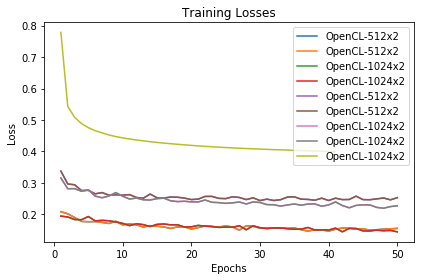

In [9]:
for (_, row), instance in zip(stats.iterrows(), instances):
    plt.plot([t.epoch_num for t in instance.model.TrainingTelemetry()], 
             [t.loss for t in instance.model.TrainingTelemetry()], 
             label=f"{row['Language']}-{row['Model size']}")

ax = plt.gca()
plt.title('Training Losses')

# X axis.
# plt.xlim((0, 50 - 1))
# ax.set_xticklabels([i + 1 for i in ax.get_xticks()])
plt.xlabel('Epochs')

# Y axis.
plt.ylabel('Loss')

plt.legend()
viz.finalise(size=(10, 8))